In [5]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind,ttest_rel
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
sns.set_theme(style="white")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False

# Set the default tick_params options for all axes
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.left'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.direction'] = 'out'


def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

## Load data

In [6]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')  # look out
subjects = data['Participant_ID'].to_list()

# set cmp template
# cmap_temp1 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
# cmap_temp2 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
cmap_temp1 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
cmap_temp2 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'


# set cmap for each subject
sub_cmap1 = [cmap_temp1.format(sub) for sub in subjects]
sub_cmap2 = [cmap_temp2.format(sub) for sub in subjects]

# set roi
pcc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/PCC/PCCk3_MNI152Nl_bin.nii.gz')
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.binarize_img(ec,5)
phc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/PHC_MNL_bin.nii.gz')
vmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')

# extract mean activity of ROI for each subjects
sub_mact1 = np.mean(masking.apply_mask(sub_cmap1, vmpfc), axis=1)
sub_mact2 = np.mean(masking.apply_mask(sub_cmap2, vmpfc), axis=1)

data['game1_act'] = sub_mact1
data['game2_act'] = sub_mact2
data['neural_diff'] = data['game2_act'] - data['game1_act']
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']

<ipython-input-6-58860a290017>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game1_act'] = sub_mact1
<ipython-input-6-58860a290017>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game2_act'] = sub_mact2
<ipython-input-6-58860a290017>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

### Plot the difference changed with age for hexagonal modulation without Phi
### Plot correlation between behavioural difference and neural difference(colour coded the dot based on age).

In [7]:
# Calculate and print the correlation
r1, p1 = pearsonr(data['Age'], data['neural_diff'])
print(f'Correlation between Age and neural difference: r={round(r1,4)}, p={round(p1,4)}')

# Calculate and print the correlation
r2, p2 = pearsonr(data['neural_diff'], data['beh_diff'])
print(f'Correlation between neural difference and behavioral difference: r={round(r2,4)}, p={round(p2,4)}')

# zscore the neural and behavioral difference
data['neural_diff'] = (data['neural_diff'] - data['neural_diff'].mean()) / data['neural_diff'].std()
data['beh_diff'] = (data['beh_diff'] - data['beh_diff'].mean()) / data['beh_diff'].std()

# Divide DataFrame into two parts and sort each part separately
df1 = data[(data['neural_diff'] > 0) & (data['beh_diff'] > 0)].sort_values(by='Age', ascending=True)
df2 = data[(data['neural_diff'] < 0) & (data['beh_diff'] < 0)].sort_values(by='Age', ascending=False)

# Concatenate them back together
sorted_df = pd.concat([df1, df2])
df3 = data[~data.index.isin(sorted_df.index)]
sorted_df = pd.concat([sorted_df, df3])

Correlation between Age and neural difference: r=0.1134, p=0.1163
Correlation between neural difference and behavioral difference: r=0.0199, p=0.7832


<ipython-input-7-dbf6f5756adb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neural_diff'] = (data['neural_diff'] - data['neural_diff'].mean()) / data['neural_diff'].std()
<ipython-input-7-dbf6f5756adb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = (data['beh_diff'] - data['beh_diff'].mean()) / data['beh_diff'].std()


<ipython-input-8-ca2cdd1a7649>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)


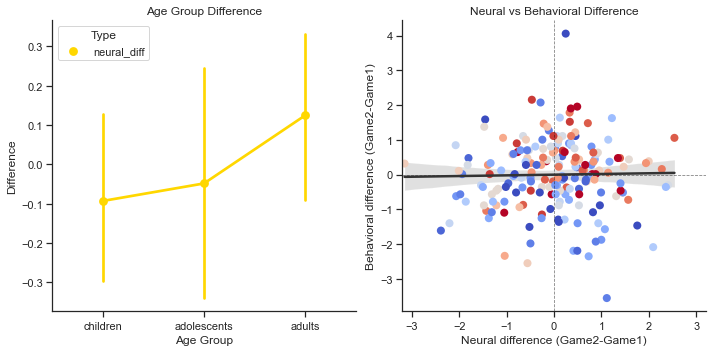

In [8]:
# Plot the data
# Add age group categories
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
data['Age_group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

# Melt the data for easier plotting
color1 = sns.color_palette("Set2")[1:3]
color2 = ['grey']
color_vmpfc = ['#F7E98E']
data_melted = data.melt(id_vars=['Age_group'], value_vars=['neural_diff'],
                        var_name='Type', value_name='difference')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first graph
sns.pointplot(x='Age_group', y='difference', hue='Type', data=data_melted,
              palette=color_vmpfc, ax=ax[0])
ax[0].set_title('Age Group Difference')
ax[0].set_xlabel("Age Group")
ax[0].set_ylabel("Difference")

# Plot the second graph
ax[1].axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=0.8)
ax[1].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=0.8)
sns.regplot(x='neural_diff', y='beh_diff', data=data, color='#333333',truncate=True,
            scatter=False, ci=95, line_kws={'alpha': 1,'linewidth':2.5}, ax=ax[1])
age = sorted_df['Age']
sc = ax[1].scatter(x='neural_diff', y='beh_diff', data=sorted_df, c=age, cmap='coolwarm',
              s=65, marker='o', edgecolor='None', linewidths=0.3, zorder=1)
#fig.colorbar(sc, ax=ax[1], label='Age', shrink=0.5, ticks=[8,16,25],location='top')
ax[1].set_xlabel('Neural difference (Game2-Game1)')
ax[1].set_ylabel('Behavioral difference (Game2-Game1)')
ax[1].set_title('Neural vs Behavioral Difference')
ax[1].set_xlim([-3.2,3.2])
fig.tight_layout()
savepath = r'/mnt/workdir/DCM/Result/paper/sf/sf6/Distance_diff_ROI_vmPFC.pdf'
plt.savefig(savepath , dpi=300, bbox_inches='tight', transparent=True, pad_inches=0)
plt.show()

## Mediation relationship between age, neural difference and behavioural difference


In [23]:
import pingouin as pg

iv = 'Age'
m = ['neural_diff_HC']
dv = 'beh_diff'

# Standardize the data
data['Age'] = (data['Age'] - data['Age'].mean()) / data['Age'].std()
data['neural_diff'] = (data['neural_diff'] - data['neural_diff'].mean()) / data['neural_diff'].std()
data['beh_diff'] = (data['beh_diff'] - data['beh_diff'].mean()) / data['beh_diff'].std()

# Mediation analysis
mediation_results,indirect_beta_sample = pg.mediation_analysis(data=data, x=iv, m=m, y=dv, seed=42,n_boot=10000,return_dist=True)
mediation_results.to_csv(r'/mnt/workdir/DCM/Result/paper/figure5/Mediation_neural_diff_HC.csv',index=False)
np.save(r'/mnt/workdir/DCM/Result/paper/figure5/Mediation_neural_diff_HC.npy',indirect_beta_sample)

<ipython-input-23-eadb9e069c43>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age'] = (data['Age'] - data['Age'].mean()) / data['Age'].std()
<ipython-input-23-eadb9e069c43>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['neural_diff'] = (data['neural_diff'] - data['neural_diff'].mean()) / data['neural_diff'].std()
<ipython-input-23-eadb9e069c43>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [50]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats  import ttest_1samp
import statsmodels.formula.api as smf

def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects


# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'neural_diff'
dv = 'beh_diff'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv,1000)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

Bootstrapped 95% confidence interval for the indirect effect: (-0.00187865, 0.06081130)


In [ ]:
# Calculate lower and upper bounds
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

# Plot histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"{m}'s Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.7f}, {upper:.7f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [83]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')  # look out
subjects = data['Participant_ID'].to_list()

# set cmp template
cmap_temp1 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
cmap_temp2 = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'

sub_cmap1 = [cmap_temp1.format(sub) for sub in subjects]
sub_cmap2 = [cmap_temp2.format(sub) for sub in subjects]

# set roi
roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
# # #lroi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.caudalanteriorcingulate.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.rostralanteriorcingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.rostralanteriorcingulate.nii.gz')
#roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# rh.isthmuscingulate.nii.gz'
# extract mean activity of ROI for each subjects
sub_mact1 = np.mean(masking.apply_mask(sub_cmap1, roi), axis=1)
sub_mact2 = np.mean(masking.apply_mask(sub_cmap2, roi), axis=1)

# sub_mact4 = np.mean(masking.apply_mask(sub_cmap4, vmpfc), axis=1)
data['game1_act'] = sub_mact1
data['game2_act'] = sub_mact2

<ipython-input-83-4a45028af3c5>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game1_act'] = sub_mact1
<ipython-input-83-4a45028af3c5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game2_act'] = sub_mact2


Text(0, 0.5, 'Mean activity of RSC')

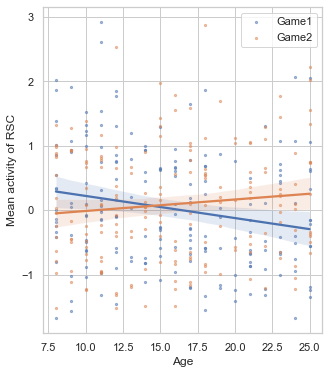

In [85]:
fig,ax = plt.subplots(figsize=(5,6))
sns.regplot(data=data,x='Age',y='game1_act',scatter_kws={'alpha':0.5,'s':5},label='Game1')
sns.regplot(data=data,x='Age',y='game2_act',scatter_kws={'alpha':0.5,'s':5},label='Game2')
ax.legend()
ax.set_ylabel('Mean activity of RSC')
#plt.savefig(r"/mnt/workdir/DCM/Result/paper/figure5/ACC_activity_2Game2withAge.pdf",dpi=300,bbox_inches="tight")

In [84]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

# set
a1 = data['Age']
b1 = data['game1_act']

a2 = data['Age']
b2 = data['game2_act']

# get the correlation coefficients
r1,p1 = pearsonr(a1,b1)
r2,p2 = pearsonr(a2,b2)

# Sample sizes for each correlation coefficient
n1 = len(a1)
n2 = len(a2)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

-0.19956503903542017 0.0053945007016126326
0.10889377100550285 0.1316928766325701
(3.037167256283812, 0.0011940645237369374)
